**Survival Analysis**

Survival Analysis done in conjunction with Clinical Risk Prediction Model with UCI Heart Failure Clinical Records dataset.

Models/Methods used:


*   The Kaplan-Meier Model
*   Log-rank test
*   Cox Proportional Hazards Model
*   Assumption testing + sensitivity checks





**Research Question**:  How do clinical features relate to time-to-death in heart failure patients?

Outcome Format (survival)


*   Duration: `time` (follow-up time)
*   Event indicator: `DEATH_EVENT` (1 = died, 0 = censored/alive at end of follow-up)



In [ ]:
# import + install <lifelines> for survival analysis tools

!pip -q install lifelines
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.8 MB/s eta 0:00:00


In [ ]:
# load data
df = pd.read_csv("/content/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
print(df.shape)
df[['time', 'DEATH_EVENT']].describe()
df['DEATH_EVENT'].value_counts()

(299, 13)


,count
DEATH_EVENT,
0,203
1,96


To estimate the probability of survival over time while accounting for censoring, The Kaplan-Meier curve was used to visualize and interpret. The dataset was split into lower vs higher ejection.

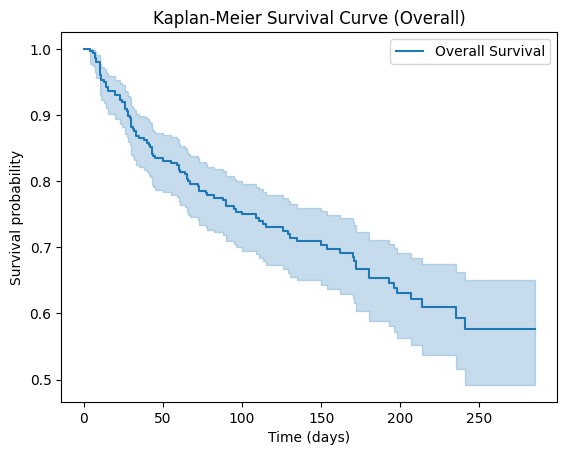

In [ ]:
kmf = KaplanMeierFitter()

T = df["time"]
E = df["DEATH_EVENT"]

kmf.fit(T, event_observed=E, label="Overall Survival")
kmf.plot()
plt.title("Kaplan-Meier Survival Curve (Overall)")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.show()

The Kaplan-Meier curve estimates the probability of survival over time while accounting for censoring. Survival declines steadily across the follow-up period, with the largest drop occurring early in follow-up. By approximately 250 days, estimated survival probability is roughly 0.60, suggesting that about 40% of patients experienced the event during the study period. The widening confidence interval at later time points reflects increased uncertainty due to fewer patients remaining under observation.


*The Kaplan-Meier curve takeaways/summary:*

*   Mortality risk accumulates over follow-up time.
*   The biggest survival drop happens earlier in follow-up.
* Long-term estimates are less precise due to fewer patients remaining under observation.



Comparing survival by low vs higher ejection fraction; do patients with low ejection fraction have worse survival over time than those with a higher ejection fraction?

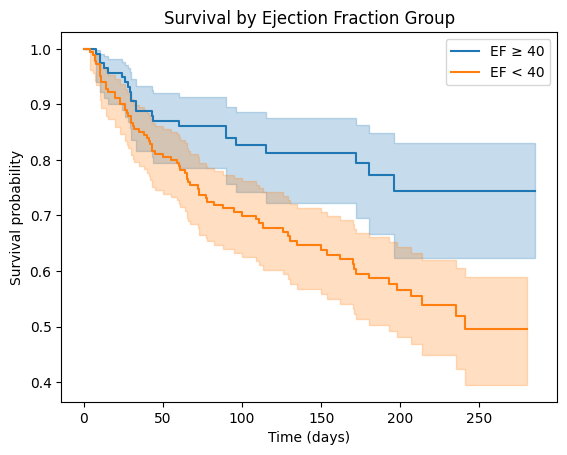

In [ ]:
df["low_ef"] = (df["ejection_fraction"] < 40).astype(int) # creating the group variable

group0 = df[df["low_ef"] == 0] # low EF
group1 = df[df["low_ef"] == 1] # high EF
# two separate Kaplan-Meier objects to depict 2 curves
kmf0 = KaplanMeierFitter() # high EF
kmf1 = KaplanMeierFitter() # low EF
# plot
ax = plt.subplot(111)

kmf0.fit(group0["time"], group0["DEATH_EVENT"], label="EF ≥ 40")
kmf0.plot(ax=ax)

kmf1.fit(group1["time"], group1["DEATH_EVENT"], label="EF < 40")
kmf1.plot(ax=ax)

plt.title("Survival by Ejection Fraction Group")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.show()

The survival probability differed meaningfully between ejection fraction groups. Patients with EF < 40 demonstrated consistently lower survival probability across follow-up compared to patients with EF ≥ 40. The difference appears early within follow-up and persists over time. This ultimately suggests that reduced ejection fraction is associated with increased mortality risk. Confidence intervals widen at later time points due to fewer patients remaining under observation, typically expected within survivaly analysis.

Comparison suggests that reduced EF means significantly decreased cardiac pumping leading to worse perfusion which ultimately leads to higher mortality risk.

**Log-rank test**

To determine whether or not survival curves differ significantly between groups, the log-rank test was performed on the dataset.  

Although the curves appear different visually, the groups should be tested to see if there is statistical significance.

In [ ]:
results = logrank_test(
    group0["time"], group1["time"],
    event_observed_A=group0["DEATH_EVENT"],
    event_observed_B=group1["DEATH_EVENT"]
)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.47 <0.005      8.90

A log-rank test was performed to compare survival between ejection fraction groups. The test was able to show a statistically significant difference in survival. This indicates that patients that have reduced ejection fraction have significantly different survival outcomes compared to patients that have a higher ejection fraction, supporting the visual separation observed by the Kaplan-Meier survival curves.

*Log rank test key takeaways/summary*:

*   `test_statistic` = 9.47
*   `p-value` = <0.005
*   p-value suggests highly strong evidence against the null hypothesis.
*   Low EF patients have significantly worse survival over time.



**Cox Proportional Hazards Model**

In order to interpret and understand which predictors may impact the risk of death with time, a Cox Proportional Hazards Model was used.

*Note*: I evaluated model refinement approaches through feature scaling and penalized Cox regression. However, there was minimal improvement found (C-index remained approximately 0.74). This suggests the baseline model already captured the available signal.

Given the small sample size and limited number of clinical predictors within the dataset, large improvements within discrimination were not expected. As refinement approaches did not improve model performance, the original Cox model was retained.

In [ ]:
# REFINEMENT APPROACHES -- for reference
# cox_df = df.drop(columns=["low_ef"]) # predictor
# df["log_cpk"] = np.log1p(df["creatinine_phosphokinase"])
# df["log_platelets"] = np.log1p(df["platelets"])
# cph = CoxPHFitter(penalizer=1)
# cph.fit(cox_df, duration_col="time", event_col="DEATH_EVENT")
# cph.print_summary()  #summary

In [ ]:
cox_df = df.drop(columns=["low_ef"]) # predictor
cph = CoxPHFitter()
cph.fit(cox_df, duration_col="time", event_col="DEATH_EVENT")
cph.print_summary()  #summary

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -467.43
         time fit was run = 2026-02-01 07:29:36 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
age                       0.05      1.05      0.01            0.03            0.07                1.03                1.07
anaemia                   0.47      1.60      0.22            0.05            0.90                1.05                2.46
creatinine_phosphokinase  0.00      1.00      0.00            0.00            0.00                1.00                1.00
diabetes                  0.15      1.16      0.22           -0.29            0.59                0.75                1.80
ejection_fraction        -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
high_blood_pressure       0.49      1.63      0.22            0.06            0.91                1.06                2.49
platelets                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
serum_creatinine          0.31      1.37      0.07            0.17            0.45                1.19                1.57
serum_sodium             -0.05      0.96      0.02           -0.09            0.00                0.91                1.00
sex                      -0.22      0.80      0.25           -0.71            0.27                0.49                1.31
smoking                   0.09      1.10      0.25           -0.40            0.59                0.67                1.80
log_cpk                  -0.16      0.85      0.14           -0.43            0.11                0.65                1.12
log_platelets            -0.37      0.69      0.59           -1.53            0.79                0.22                2.19

                          cmp to     z      p  -log2(p)
covariate                                              
age                         0.00  4.98 <0.005     20.58
anaemia                     0.00  2.17   0.03      5.05
creatinine_phosphokinase    0.00  2.48   0.01      6.24
diabetes                    0.00  0.66   0.51      0.98
ejection_fraction           0.00 -4.65 <0.005     18.19
high_blood_pressure         0.00  2.25   0.02      5.35
platelets                   0.00  0.40   0.69      0.54
serum_creatinine            0.00  4.40 <0.005     16.47
serum_sodium                0.00 -1.89   0.06      4.10
sex                         0.00 -0.87   0.38      1.39
smoking                     0.00  0.37   0.71      0.48
log_cpk                     0.00 -1.15   0.25      2.00
log_platelets               0.00 -0.63   0.53      0.92
---
Concordance = 0.74
Partial AIC = 960.87
log-likelihood ratio test = 83.54 on 13 df
-log2(p) of ll-ratio test = 38.62

CPH Model Takeaway/Summary:

A Cox ProportionalHazards Model was used in order to evaluate associations between clinical variables and mortality risk. The model demonstrated good discrimination (concordance = 0.74). Significant predictors of increased mortality risk included older age (HR 1.05), anemia (HR 1.58), high blood pressure (HR 1.61), and higher serum creatinine levels (HR 1.38). Higher ejection fraction was protective (HR 0.95). These findings are consistent with known clinical risk factors within heart failure populations.

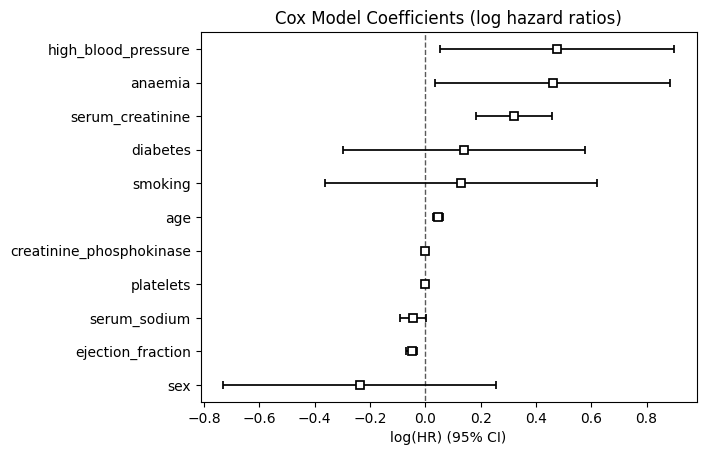

In [ ]:
# plotting CPH
cph.plot()
plt.title("Cox Model Coefficients (log hazard ratios)")
plt.show()

**Strong Risk Increasing Predictors:**


*   High Blood Pressure
*   Anaemia
*   Serum Creatinine (Kidney dysfunction is strongly associated with mortality)
*   Age (older/higher)

**Borderline/Not Significant Predictors**
*   Serum Sodium (Borderline)
*   Diabetes (Uncertain)
*   Smoking (Uncertain)
*   Sex (Uncertain)

The Cox efficient plot shows estimated log hazard ratios and 95% CI for each of the predictors within the dataset. High blood pressure, anaemia, serum creatinine, and age were associated with increased mortality risk, while higher ejection fraction was protective. Variables with confidence intervals crossing zero were not statistically significant independent predictors in this model. The stability of key predictors across modeling approaches supports the robustness of these associations.

In [ ]:
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots = False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic    p  -log2(p)
age                      km              0.11 0.74      0.43
                         rank            0.03 0.86      0.21
anaemia                  km              0.00 1.00      0.00
                         rank            0.01 0.93      0.11
creatinine_phosphokinase km              1.13 0.29      1.79
                         rank            1.11 0.29      1.77
diabetes                 km              0.04 0.84      0.25
                         rank            0.00 0.99      0.02
ejection_fraction        km              5.85 0.02      6.00
                         rank            6.21 0.01      6.30
high_blood_pressure      km              0.11 0.74      0.44
                         rank            0.11 0.74      0.44
platelets                km              0.04 0.85      0.24
                         rank            0.11 0.74      0.44
serum_creatinine         km              3.22 0.07      3.78
                         rank            3.48 0.06      4.00
serum_sodium             km              1.10 0.29      1.76
                         rank            1.73 0.19      2.41
sex                      km              0.09 0.76      0.39
                         rank            0.26 0.61      0.71
smoking                  km              0.58 0.45      1.16
                         rank            0.33 0.57      0.82



1. Variable 'ejection_fraction' failed the non-proportional test: p-value is 0.0127.

   Advice 1: the functional form of the variable 'ejection_fraction' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ejection_fraction' using pd.cut, and then specify it in
`strata=['ejection_fraction', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Prop

[]

After performing the assumption check, it was found that most of the variables that are included within the dataset pass the proportional hazards assumption. However, the ejection fraction was flagged as a possible PH violation, which is not uncommon in clinical survival modeling. There are several factors that can contribute to (although not limited to) EF being flagged as a possible PH violation such as early clinical decompensation, changes in treatment over time, or the increased weight of EF at more severe stages of disease.

EF can also present itself being flagged as it is generally clinically heterogeneous. Additionally, the dataset was small with limited covariate, and The Cox Proportional Hazards Model assumes that the effect of predictors remains constant over time. Given the overall stability of the model, as well as clinical interpretability, the model was retained while noting this as a potential limitation.

**Discussion & Limitations**

This analysis evalated time-to-mortality in heart failure patients using Kaplan-Meier survival analysis, log-rank testing, and Cox proportional hazards modeling. Survival differed significantly by ejection fraction (cardiac pumping efficiency) group. Lower EF was associated with reduced survival probability. Multivariable Cox modeling identified age, anaemia, high blood pressure, and serum creatinine as significant predictors of increased mortality risk, whereas higher EF was protective (indicating the heart is pumping a sufficient percentage of blood out of the body with each beat). These findings are consistent with known clinical risk factors within heart failure populations.

Model refinement approaches, including feature scaling and penalized Cox regression, were evaluated but did not meaningfully improve the model's performance. This suggests that the baseline Cox model was able to capture the majority of the predictive signals that were available within the dataset.

There are several limitations within the dataset and model that should be considered. The dataset utilized for this model was relatively small, limiting statistical power and model generalizability. Additionally, the dataset consisted of a limited set of clinical variables. Important predictors such as, but not limited to, medicine use and longitudinal clinical changes were not available. Lastly, a mild deviation from the proportional hazards assumption was observed for ejection fraction, reflecting time-varying clinical effects rather than model misspecification. It is also important to note that external validation was not performed, therefore this model may perform different within other clinical populations.  

Future work could explore larger datasets, as well as more diverse patient populations incorporating additional clinical and treatment variables.